In [1]:
from keras.models import Sequential
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Flatten, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam
import utils as utils
from keras.metrics import Recall, Precision, F1Score
from sklearn.model_selection import train_test_split


DATA_FILE_PATH = 'data.json'

In [2]:
train_tups, test_tups = utils.split_data(utils.generate_tuples_from_file(DATA_FILE_PATH, num_samples=10000), test_size=0.2)

print('Training set size: ', len(train_tups[0]))
print('Test set size: ', len(test_tups[0]))
print('Sample tokenized review: ', train_tups[0][0])
print('Sample rating: ', train_tups[1][0])

Training set size:  8000
Test set size:  2000
Sample tokenized review:  ['The', 'food', 'is', 'very', 'good', 'but', 'the', 'ability', 'to', 'turnover', 'the', 'tables', 'is', 'a', 'huge', 'problem', 'on', 'busy', 'days', '.', 'Waited', 'over', 'an', 'hour', 'to', 'be', 'seated', 'today', 'and', 'about', 'an', 'hour', 'to', 'get', 'food', '.', 'I', 'just', 'do', 'not', 'have', '2', 'hours', 'available', 'to', 'get', 'breakfast', '.', 'They', 'do', 'not', 'have', 'the', 'proper', 'staffing', 'to', 'quickly', 'get', 'the', 'food', 'out', 'and', 'clear', 'tables', 'in', 'a', 'timely', 'fashion', '.', 'There', 'were', 'many', 'upset', 'people', 'there', 'due', 'to', 'the', 'time', 'to', 'wait', '.', 'While', 'we', 'were', 'eating', 'there', 'were', '2', 'empty', 'tables', 'for', 'at', 'least', '15', 'minutes', 'that', 'they', 'did', 'not', 'seat', 'anyone', 'at', 'yet', 'when', 'we', 'left', 'there', 'was', 'a', 'longer', 'line', 'than', 'when', 'I', 'arrived', 'which', 'we', 'waited', 'an

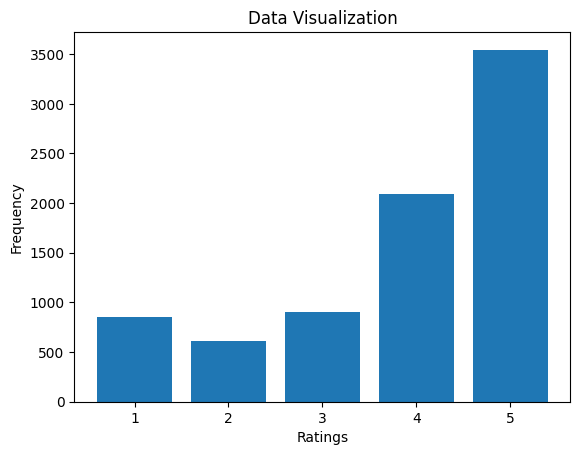

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(train_tups[1])

ratingCounts = list(counter.keys())
values = list(counter.values())

plt.bar(ratingCounts, values)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Data Visualization')
plt.show()

In [4]:
from sklearn.utils import class_weight

reviews = train_tups[0]
ratings = train_tups[1]
ratings = [rating - 1 for rating in ratings]

testReviews = test_tups[0]
testRatings = test_tups[1]
testRatings = [rating - 1 for rating in testRatings]

max_words = 100000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

test_sequences = tokenizer.texts_to_sequences(testReviews)

max_sequence_length = 200
padded_sequences = pad_sequences(sequences=sequences, maxlen=max_sequence_length)
padded_test_sequences = pad_sequences(sequences=test_sequences, maxlen=max_sequence_length)
categorical_ratings = to_categorical(ratings, num_classes=5)
categorical_test_ratings = to_categorical(testRatings, num_classes=5)


class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(categorical_ratings, axis=1)), y=np.argmax(categorical_ratings, axis=1))
class_weight_dict = dict(enumerate(class_weights))


embedding_dim = 120
recall = Recall()
precision = Precision()
f1_scores = F1Score()

In [5]:
model  = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(SimpleRNN(units=50, activation='relu'))
model.add(Flatten())
model.add(Dense(50,activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.summary()
model.compile(optimizer=Adam(learning_rate=.001), loss='categorical_crossentropy',  metrics=['accuracy', recall, precision, f1_scores])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 120)          12000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                8550      
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 12011355 (45.82 MB)
Trainable params: 1201

In [6]:
history = model.fit(padded_sequences, categorical_ratings, class_weight=class_weight_dict, validation_data=(padded_test_sequences, categorical_test_ratings), batch_size=500, epochs=20)

Epoch 1/20
16/16 [==============================] - 5s 255ms/step - loss: 1.6100 - accuracy: 0.1713 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1_score: 0.1375 - val_loss: 1.6159 - val_accuracy: 0.1105 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.0398
Epoch 2/20
16/16 [==============================] - 3s 204ms/step - loss: 1.6096 - accuracy: 0.1751 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1_score: 0.1532 - val_loss: 1.6109 - val_accuracy: 0.1175 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.0533
Epoch 3/20
16/16 [==============================] - 4s 228ms/step - loss: 1.6069 - accuracy: 0.2101 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1_score: 0.1878 - val_loss: 1.6083 - val_accuracy: 0.2355 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.1582
Epoch 4/20
16/16 [==============================] - 4s 219ms/step - loss: 1.6015 - accuracy: 0.2834 - recall: 0.0000e+00 - precision: 0.0000e+00 - f1_scor

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions = model.predict(padded_test_sequences)
one_hot_predictions = np.zeros_like(predictions)
one_hot_predictions[np.arange(len(predictions)), np.argmax(predictions, axis=1)] = 1

accuracy = accuracy_score(categorical_test_ratings, one_hot_predictions)
precision = precision_score(categorical_test_ratings, one_hot_predictions, average='weighted')
recall = recall_score(categorical_test_ratings, one_hot_predictions, average='weighted')
f1 = f1_score(categorical_test_ratings, one_hot_predictions, average='weighted')

print(f"Accuracy : {accuracy}")
print(f"Precision_Score : {precision}")
print(f"Recall Score : {recall}")
print(f"F1 Score : {f1}")




63/63 [==============================] - 0s 5ms/step
Accuracy : 0.546
Precision_Score : 0.49736520069647117
Recall Score : 0.546
F1 Score : 0.48789065333104303


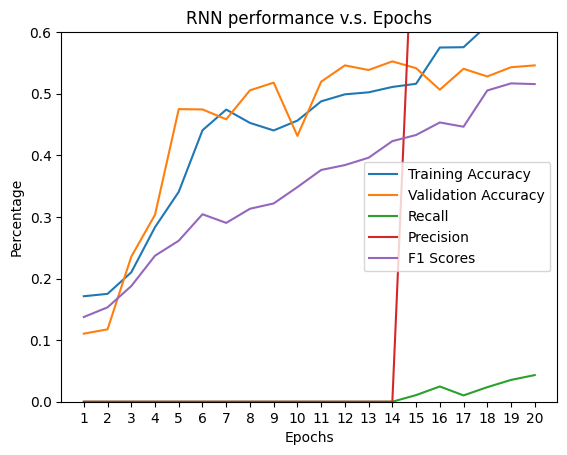

<Figure size 640x480 with 0 Axes>

In [8]:

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
f1_scores = history.history['f1_score']
recall_scores = history.history['recall']
precisions = history.history['precision']

averagedF1ScoresList = []
for f1_score_list in f1_scores:
    average = sum(f1_score_list)/5
    averagedF1ScoresList.append(average)


epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, recall_scores, label='Recall')
plt.plot(epochs, precisions, label='Precision')
plt.plot(epochs, averagedF1ScoresList, label='F1 Scores')
plt.ylim(0, 0.6)
plt.xlabel('Epochs')
plt.ylabel('Percentage')
plt.title('RNN performance v.s. Epochs')
plt.xticks(range(1,21,1))
plt.legend()
plt.show()

plt.savefig('RNN.png')